In [18]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
report_2019 = pd.read_csv('data/baq_policia_2019.csv')
report_2020 = pd.read_csv('data/baq_policia_2020.csv')
report_2021 = pd.read_csv('data/baq_policia_2021.csv')

In [68]:
report_2019.rename(columns={
    'Estacion':'estacion',
    'Fecha inicial':'fecha_inicial',
    'Fecha final':'fecha_final',
    'RGlobal':'rglobal'
    }, inplace=True)

report_2020.rename(columns={
    'Estacion':'estacion',
    'Fecha inicial':'fecha_inicial',
    'Fecha final':'fecha_final',
    'RGlobal':'rglobal'
    }, inplace=True)
    
report_2021.rename(columns={
    'Estacion':'estacion',
    'Fecha inicial':'fecha_inicial',
    'Fecha final':'fecha_final',
    'RGlobal':'rglobal'
    }, inplace=True)

In [69]:
def fix_dates(df, year=None):
    df['fecha_inicial'] = pd.to_datetime(df['fecha_inicial'], format='%Y-%m-%d %H:%M')
    df['fecha_final'] = pd.to_datetime(df['fecha_final'], format='%Y-%m-%d %H:%M')
    df['fecha_inicial'] = np.where(
        df.fecha_inicial.dt.minute==59, 
        df.fecha_inicial + timedelta(minutes=1),
        df.fecha_inicial
    )
    dates = [dt.datetime(year,1,1)]
    while dates[-1] != dt.datetime(year+1,1,1,23):
        dates.append(dates[-1]+timedelta(hours=1))

    dates = pd.DataFrame({'fecha_inicial':dates})
    dates['fecha_final'] = dates.iloc[:,0] + timedelta(minutes=59)
    df = pd.merge(
        df,
        dates,
        how='right',
        on=['fecha_inicial','fecha_final']
    )
    df['fecha'] = df.fecha_inicial.dt.date
    df['año'] = year
    df['mes'] = df.fecha_inicial.dt.month
    df['dia'] = df.fecha_inicial.dt.day
    df['inicio_medicion'] = df.fecha_inicial.dt.hour
    return df

In [70]:
report_2019 = fix_dates(report_2019, 2019)
report_2020 = fix_dates(report_2020, 2020)
# report_2021 = fix_dates(report_2021)

In [71]:
# rellenando las mediciones horarias que no se encuentran, con ceros.
report_2019.rglobal.fillna(0.0, inplace=True) 
report_2020.rglobal.fillna(0.0, inplace=True)

#Creando un reporte de la concatenacion de cada reporte anual
full_report = pd.concat([
    report_2019,
    report_2020,
], ignore_index=True)

# Eliminando registros que se encuentran en mas de un reporte
full_report.drop_duplicates(['fecha_inicial','rglobal'], inplace=True)

In [84]:
full_report[(full_report.rglobal.isna())&(full_report.inicio_medicion.between(10,15))].mes.value_counts()

4     116
12     77
9      69
5      52
11     49
8      34
10     30
3      18
6      16
7       9
2       6
Name: mes, dtype: int64

In [106]:
daily_measures = full_report.pivot(
    index=['inicio_medicion',], 
    columns=['año','fecha'], 
    values='rglobal'
)# .fillna(0.00)
monthly_mean_measures = full_report.groupby(['año','mes','inicio_medicion']).rglobal.mean().reset_index().pivot(
    index='inicio_medicion', 
    columns=['año', 'mes'], 
    values='rglobal'
)

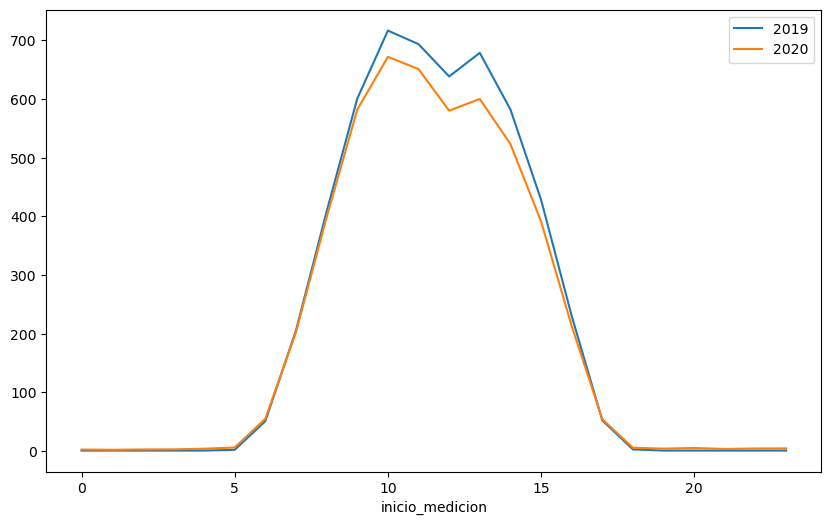

In [63]:
# sns.lineplot(y=daily_measures.mean(axis=1).values, x=results.index)

_, ax = plt.subplots(nrows=1, figsize=(10,6))
daily_measures.loc[:, daily_measures.columns.get_level_values('año')==2019].mean(axis=1).plot(ax=ax, label='2019')
daily_measures.loc[:, daily_measures.columns.get_level_values('año')==2020].mean(axis=1).plot(ax=ax, label='2020')
ax.legend()
plt.show()

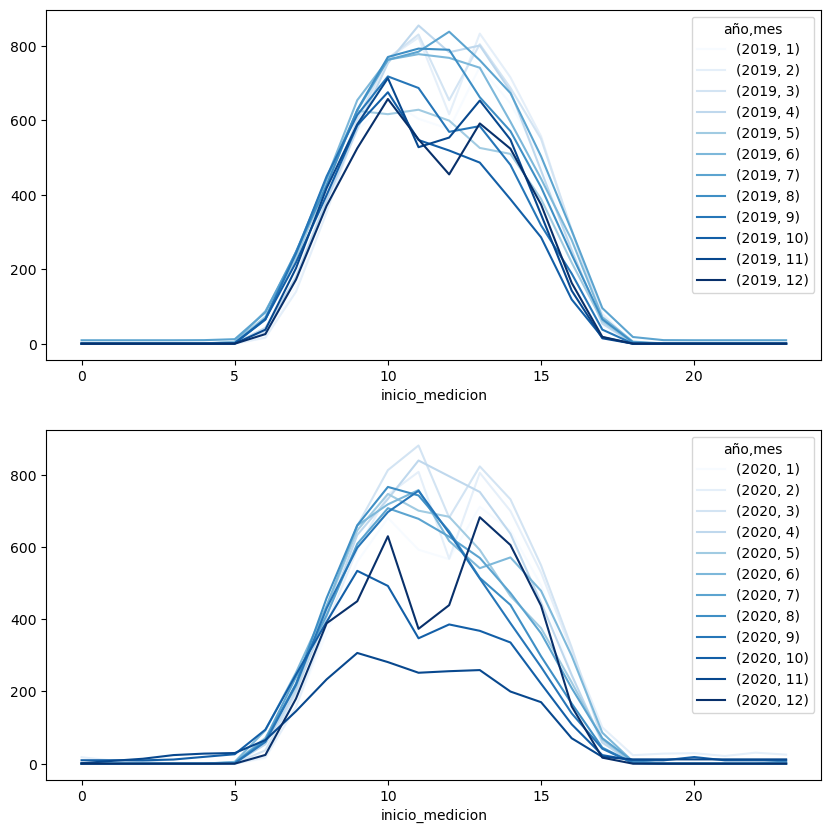

In [83]:
_, ax = plt.subplots(nrows=2, figsize=(10,10))
monthly_mean_measures.loc[:, monthly_mean_measures.columns.get_level_values('año')==2019].plot(ax=ax[0], cmap='Blues')
monthly_mean_measures.loc[:, monthly_mean_measures.columns.get_level_values('año')==2020].plot(ax=ax[1], cmap='Blues')
plt.show()

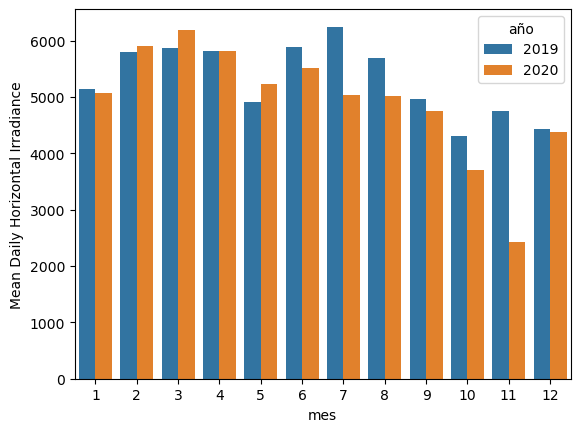

In [65]:
ax = sns.barplot(data=monthly_mean_measures.sum().reset_index(), x='mes', y=0, hue='año')
ax.set(ylabel='Mean Daily Horizontal Irradiance')
plt.show()

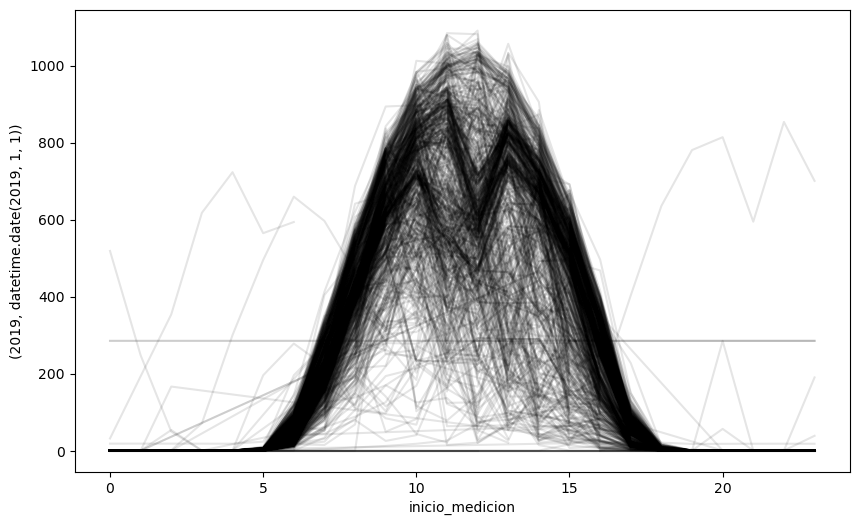

In [107]:
_, ax = plt.subplots(figsize=(10,6))
for c in daily_measures.columns:
    sns.lineplot(x=daily_measures.index, y=daily_measures[c], ax=ax, color='black', alpha=0.1)
plt.show()

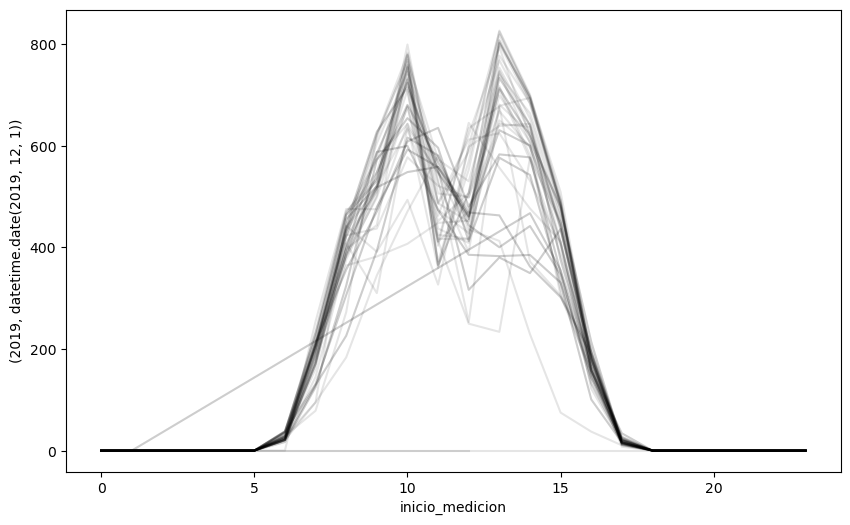

In [105]:
daily_measures = full_report[full_report.mes==12].pivot(
    index=['inicio_medicion',], 
    columns=['año','fecha'], 
    values='rglobal'
)
_, ax = plt.subplots(figsize=(10,6))
for c in daily_measures.columns:
    sns.lineplot(
        x=daily_measures.loc[:, daily_measures.columns.get_level_values('año')==2019].index, 
        y=daily_measures[c], ax=ax, color='black', alpha=0.1)
plt.show()

In [49]:
#Identificando las fechas en las cuales todas las mediciones son cero
daily_measures.loc[:,daily_measures.sum()==0].columns.get_level_values(1)

Index([2019-01-01, 2019-01-02, 2019-01-03, 2019-01-04, 2019-01-05, 2019-01-06,
       2019-01-07, 2019-01-08, 2019-01-09, 2019-01-10,
       ...
       2019-11-13, 2019-11-14, 2019-11-15, 2019-11-16, 2019-11-17, 2019-11-18,
       2019-11-19, 2019-11-20, 2019-11-21, 2020-08-09],
      dtype='object', name='fecha', length=200)

### En las siguientes celdas, se grafican de nuevo las graficas anteriores, eliminando los dias en donde no se tomaron mediciones.

In [50]:
#Filtrando dias sin registros del reporte final.
full_report = full_report[full_report.groupby('fecha').rglobal.transform(lambda x: x.sum()!=0)]

In [51]:
daily_measures = full_report.pivot(
    index=['inicio_medicion',], 
    columns=['año','fecha'], 
    values='rglobal'
)# .fillna(0.00)
monthly_mean_measures = full_report.groupby(['año','mes','inicio_medicion']).rglobal.mean().reset_index().pivot(
    index='inicio_medicion', 
    columns=['año', 'mes'], 
    values='rglobal'
)

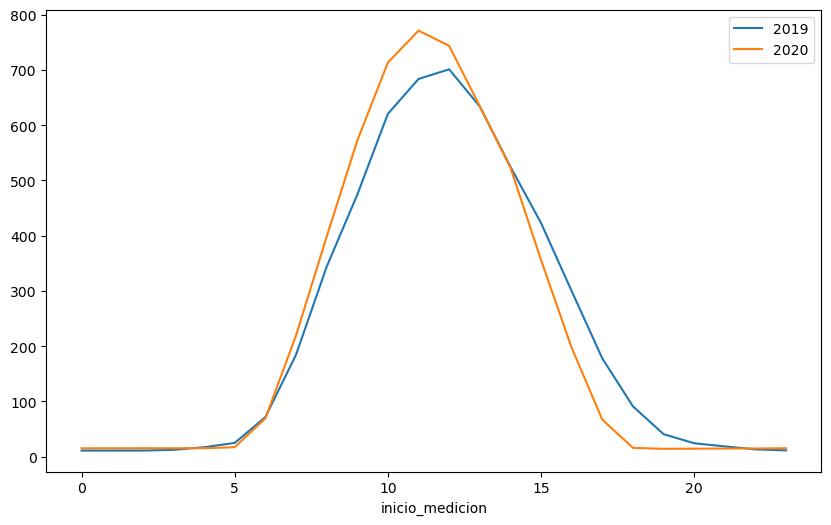

In [52]:
# sns.lineplot(y=daily_measures.mean(axis=1).values, x=results.index)

_, ax = plt.subplots(nrows=1, figsize=(10,6))
daily_measures.loc[:, daily_measures.columns.get_level_values('año')==2019].mean(axis=1).plot(ax=ax, label='2019')
daily_measures.loc[:, daily_measures.columns.get_level_values('año')==2020].mean(axis=1).plot(ax=ax, label='2020')
ax.legend()
plt.show()

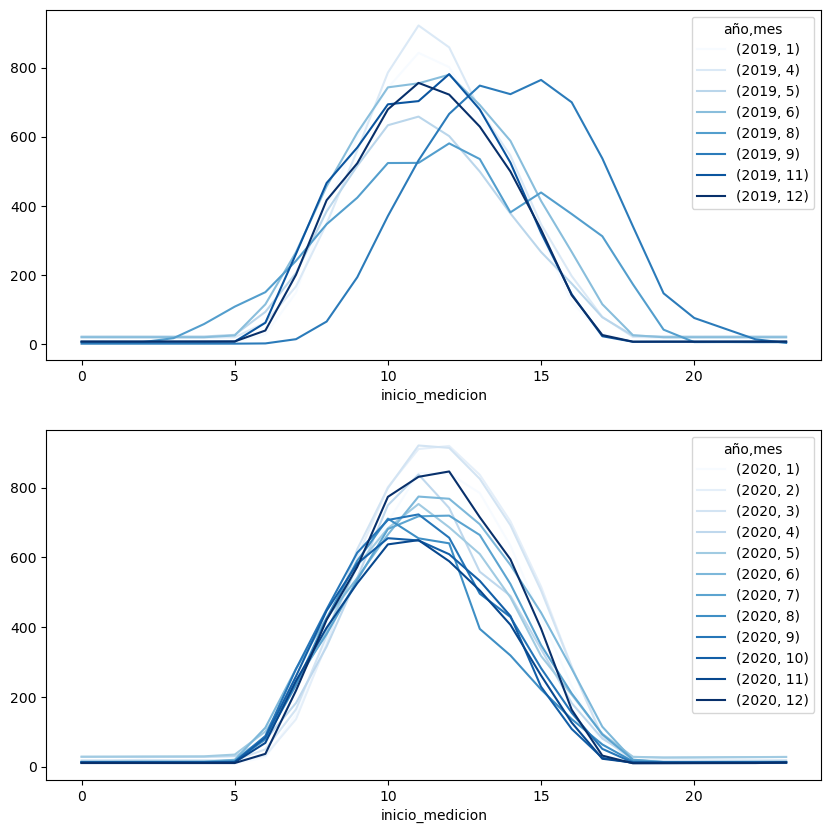

In [53]:
_, ax = plt.subplots(nrows=2, figsize=(10,10))
monthly_mean_measures.loc[:, monthly_mean_measures.columns.get_level_values('año')==2019].plot(ax=ax[0], cmap='Blues')
monthly_mean_measures.loc[:, monthly_mean_measures.columns.get_level_values('año')==2020].plot(ax=ax[1], cmap='Blues')
plt.show()

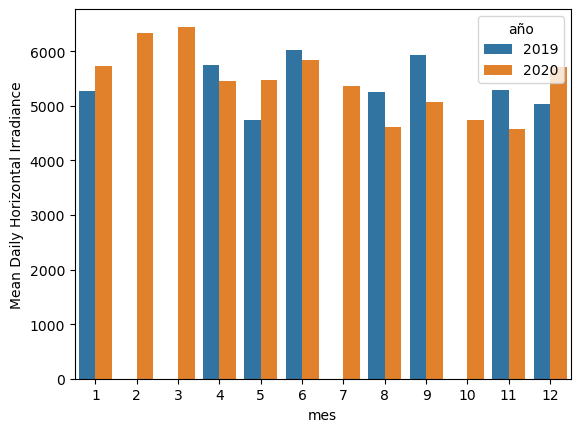

In [54]:
ax = sns.barplot(data=monthly_mean_measures.sum().reset_index(), x='mes', y=0, hue='año')
ax.set(ylabel='Mean Daily Horizontal Irradiance')
plt.show()

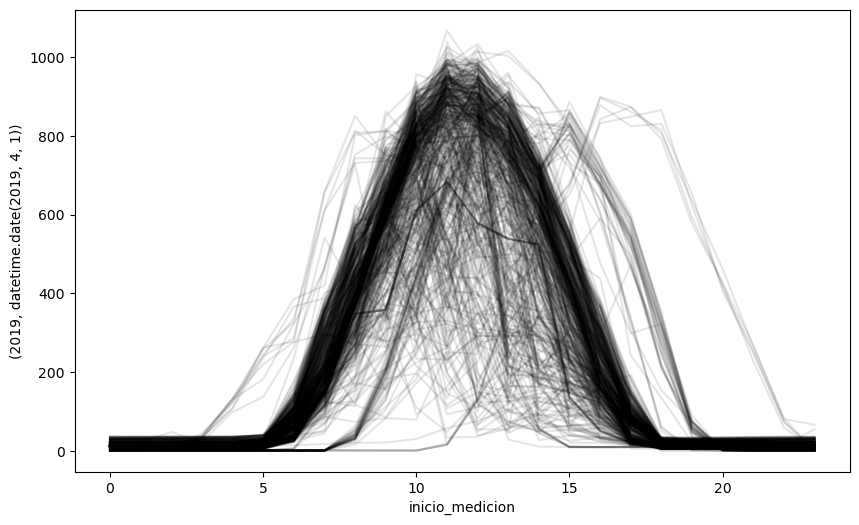

In [55]:
_, ax = plt.subplots(figsize=(10,6))
for c in daily_measures.columns:
    sns.lineplot(x=daily_measures.index, y=daily_measures[c], ax=ax, color='black', alpha=0.1)
plt.show()